In [1]:
import numpy as np
import uproot
import math

In [2]:
tree = uproot.open( "~/seed_1C0B_mltree.root:Stg" )

In [3]:
import matplotlib.pyplot as plt
fs = ( 16, 9 ) # lets make all our figures 16 by 9

In [4]:
xyzxyzt = tree.arrays( [ "Crit2_RZRatio_x1", "Crit2_RZRatio_y1", "Crit2_RZRatio_z1", "Crit2_RZRatio_x2", "Crit2_RZRatio_y2", "Crit2_RZRatio_z2", "Crit2_RZRatio_trackIds" ], library='np'  )

In [10]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
import os

In [5]:
x1 = xyzxyzt['Crit2_RZRatio_x1']
y1 = xyzxyzt['Crit2_RZRatio_y1']
z1 = xyzxyzt['Crit2_RZRatio_z1']
x2 = xyzxyzt['Crit2_RZRatio_x2']
y2 = xyzxyzt['Crit2_RZRatio_y2']
z2 = xyzxyzt['Crit2_RZRatio_z2']
tid = xyzxyzt['Crit2_RZRatio_trackIds']

In [6]:
# Check the lengths
iEvent = 120
print( len(x1))
print( len(x1[iEvent]) )
print( len(y1[iEvent]) )
print( len(z1[iEvent]) )
print( len(x2[iEvent]) )
print( len(y2[iEvent]) )
print( len(z2[iEvent]) )
print( len(tid[iEvent]) )

20000
177
177
177
177
177
177
177


## Train with (x,y,z,x,y,z)

In [ ]:
%%time

X = [[], [], [], [], [], []]
Y = []

print(len(X[1]))
print(len(Y))

# build up 1d arrays for training
for iEvent in np.arange( 0, len(x1) ) :
    for i in np.arange( 0, len(x1[iEvent]) ) :
        X[0].append( x1[iEvent][i] )
        X[1].append( y1[iEvent][i] )
        X[2].append( z1[iEvent][i] )
        
        X[3].append( x2[iEvent][i] )
        X[4].append( y2[iEvent][i] )
        X[5].append( z2[iEvent][i] )
        
        if tid[iEvent][i] > 0 :
            Y.append( 1 )
        else :
            Y.append( 0 )
            


## Train with (x,y) (dx,dy)
adjust model input accordingly

In [22]:
%%time

X = [[], [], [], [] ]
Y = []

print(len(X[1]))
print(len(Y))

# build up 1d arrays for training
for iEvent in np.arange( 0, len(x1) ) :
    for i in np.arange( 0, len(x1[iEvent]) ) :
        X[0].append( x1[iEvent][i] )
        X[1].append( y1[iEvent][i] )

        X[2].append( x2[iEvent][i] - x1[iEvent][i] )
        X[3].append( y2[iEvent][i] - y1[iEvent][i] )
        
        if tid[iEvent][i] > 0 :
            Y.append( 1 )
        else :
            Y.append( 0 )
            


0
0
CPU times: user 43.5 s, sys: 1.22 s, total: 44.7 s
Wall time: 45.1 s


## Train with (dr, dphi, dz)

In [61]:
%%time



X = [[], [], [] ]
Y = []

print(len(X[1]))
print(len(Y))



# build up 1d arrays for training
for iEvent in np.arange( 0, len(x1) ) :
    for i in np.arange( 0, len(x1[iEvent]) ) :
        phi1 = math.atan2( y1[iEvent][i], x1[iEvent][i] )
        phi2 = math.atan2( y2[iEvent][i], x2[iEvent][i] )
        dphi = math.atan2(math.sin(phi1-phi2), math.cos(phi1-phi2))
        
        r1 = math.sqrt( x1[iEvent][i]*x1[iEvent][i] + y1[iEvent][i]*y1[iEvent][i] )
        r2 = math.sqrt( x2[iEvent][i]*x2[iEvent][i] + y2[iEvent][i]*y2[iEvent][i] )
        dr = r1 - r2
        X[0].append( dphi )
        X[1].append( dr )
        X[2].append( z2[iEvent][i] - z1[iEvent][i] )
        
        if tid[iEvent][i] > 0 :
            Y.append( 1 )
        else :
            Y.append( 0 )
            


0
0
CPU times: user 1min 28s, sys: 1.12 s, total: 1min 29s
Wall time: 1min 30s


In [62]:
print(len(X[0]))
print(len(Y))

12877245
12877245


In [63]:
train_X = np.transpose( np.array( X ))
train_Y = np.array( Y )

In [64]:
print( "X=", train_X.shape )
print( "Y=", train_Y.shape )

X= (12877245, 3)
Y= (12877245,)


In [71]:
def build_model() :
    model = Sequential()
    model.add(Dense(12, input_dim=3, kernel_initializer='normal', activation='relu'))
#     model.add(Dense(12, activation='relu'))
#     model.add(Dense(12, activation='relu'))
    model.add(Dense(1))
    model.summary()
    return model

In [72]:
# Get the model built in the function above
model = build_model()
# compile the model and set the loss function, optimizer and metrics to check during training.
model.compile(loss='huber_loss', optimizer='adam', metrics=['mse','mae'])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 12)                48        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 13        
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [76]:
%%time
history = model.fit(train_X, train_Y, epochs=2, batch_size=10,  verbose=1, validation_split=0.5)

Epoch 1/2
643863/643863 [==============================] - 565s 877us/step - loss: 0.0146 - mse: 0.0293 - mae: 0.0839 - val_loss: 0.0143 - val_mse: 0.0287 - val_mae: 0.0755
Epoch 2/2
643863/643863 [==============================] - 547s 849us/step - loss: 0.0142 - mse: 0.0284 - mae: 0.0829 - val_loss: 0.0141 - val_mse: 0.0283 - val_mae: 0.0778
CPU times: user 25min 29s, sys: 3min 4s, total: 28min 34s
Wall time: 18min 32s


dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


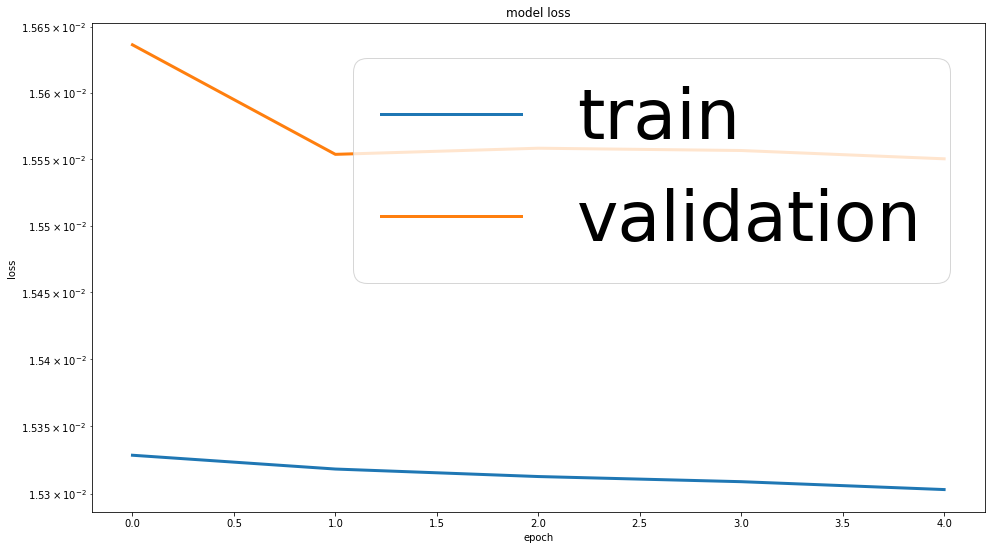

In [75]:
plt.figure(figsize=fs)
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'], linewidth=3)
plt.plot(history.history['val_loss'], linewidth=3)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right', prop={'size': 70})
# plt.gca().set_ylim((0, 1))
plt.semilogy()
plt.show()

In [69]:
pred_Y = np.array(model.predict(train_X[:40000]))

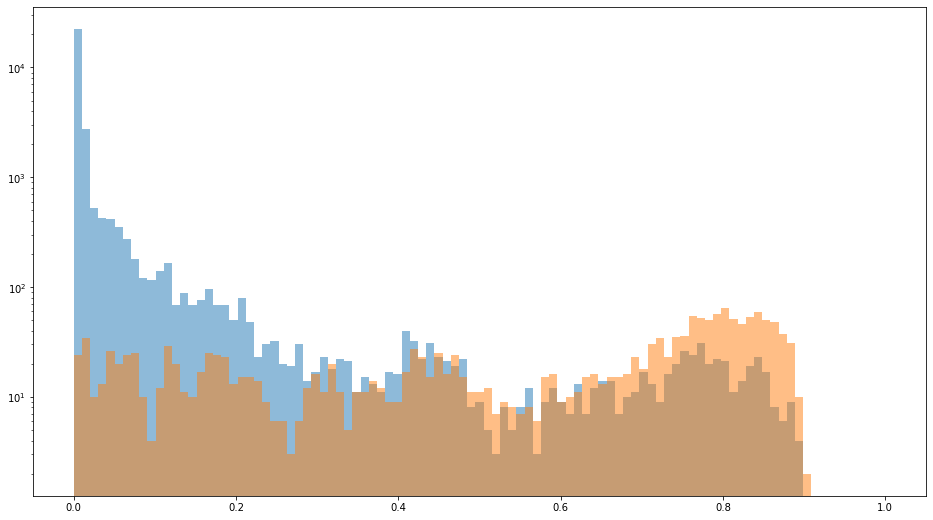

In [70]:
plt.figure(figsize=fs)
plt.hist( [ y0[0] for y0, y1 in zip(pred_Y[:40000], train_Y[:40000]) if y1 == 0 ], bins=np.linspace( 0, 1.0, 100 ), alpha=0.5 )
plt.hist( [ y0[0] for y0, y1 in zip(pred_Y[:40000], train_Y[:40000]) if y1 == 1 ], bins=np.linspace( 0, 1.0, 100 ), alpha=0.5 )
plt.semilogy()
plt.show()

In [43]:
import tensorflow.python.keras as k

In [45]:
dir(k.losses)

['BCE',
 'BinaryCrossentropy',
 'CategoricalCrossentropy',
 'CategoricalHinge',
 'CosineSimilarity',
 'Hinge',
 'Huber',
 'K',
 'KLD',
 'KLDivergence',
 'LABEL_DTYPES_FOR_LOSSES',
 'LogCosh',
 'Loss',
 'LossFunctionWrapper',
 'MAE',
 'MAPE',
 'MSE',
 'MSLE',
 'MeanAbsoluteError',
 'MeanAbsolutePercentageError',
 'MeanSquaredError',
 'MeanSquaredLogarithmicError',
 'Poisson',
 'SparseCategoricalCrossentropy',
 'SquaredHinge',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_maybe_convert_labels',
 'abc',
 'absolute_import',
 'ag_ctx',
 'array_ops',
 'autograph',
 'bce',
 'binary_crossentropy',
 'categorical_crossentropy',
 'categorical_hinge',
 'context',
 'cosine_similarity',
 'deserialize',
 'deserialize_keras_object',
 'dispatch',
 'distribution_strategy_context',
 'division',
 'doc_controls',
 'get',
 'hinge',
 'huber',
 'huber_loss',
 'is_categorical_crossentropy',
 'keras_export',
 'kl_divergence',
 'kld',
 'kullb

In [59]:
import math